In [200]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn as nn

from preprocess._utils import *
import torch.optim as optimizer
from torch.autograd import Variable
from models._main import *
from preprocess._utils import *
import torch.nn as nn
import torch.utils.data as Data
from train._main import *
from data._utils import *
from models._utils import *

In [201]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")


## Hyperparameters

In [202]:
time_step = 3
num_neurons = 10
INPUT_SIZE = num_neurons
HIDDEN_SIZE = 100
BATCH_SIZE = 128
EPOCH = 100
LR = 0.1  # learning rate
DROP_RATE = 0.2  # drop out
LAYERS = 2  # hidden layer
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Model

In [203]:
class lstm(nn.Module):
    def __init__(self, INPUT_SIZE, HIDDEN_SIZE, LAYERS, DROP_RATE):
        super(lstm, self).__init__()
        self.rnn = nn.LSTM(
            input_size=INPUT_SIZE,
            hidden_size=HIDDEN_SIZE,
            num_layers=LAYERS,
            dropout=DROP_RATE,
            batch_first=True,
            # bidirectional=True,
        )
        self.hidden_out = nn.Linear(HIDDEN_SIZE, INPUT_SIZE)
        self.h_s = None
        self.h_c = None

    def forward(self, x):
        r_out, (h_s, h_c) = self.rnn(x)
        # print(r_out.shape)
        # print(r_out[:, :, -1:].shape)
        output = self.hidden_out(r_out)
        # print(output.shape)
        return output

## Data Preprocess

## DataLoader

In [204]:
dataset = get_dataset(OmegaConf.load("../conf/dataset.yaml"))
worm = "worm0"
cutdown = 3312
cutneuron = num_neurons
calcium_data = dataset[worm]["calcium_data"][:cutdown, :cutneuron].to(torch.float32)
residual_calcium = dataset[worm]["residual_calcium"][:cutdown, :cutneuron].to(torch.float32)

# train and test
train_size = int(0.8 * cutdown)
test_size = cutdown - train_size

train_ca, test_ca = calcium_data.split(train_size, dim=0)
train_res, test_res = residual_calcium.split(train_size, dim=0)

print(train_ca.shape)

Chosen dataset(s): ['Uzel2022']
Num. worms: 6
Worm names: ['worm0', 'worm1', 'worm2', 'worm3', 'worm4', 'worm5']


torch.Size([2649, 10])


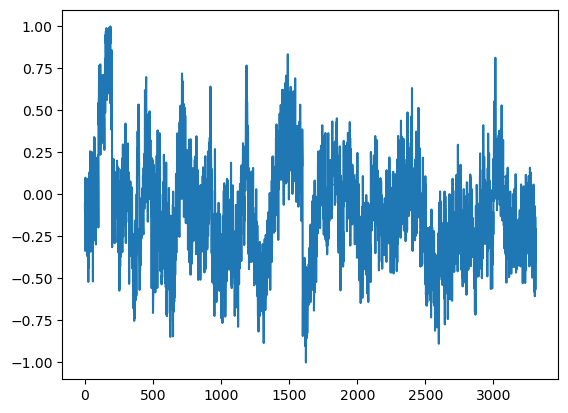

In [205]:
plt.plot(calcium_data[:, 0])
plt.show()

In [206]:
train_loop_cal = []
train_loop_res = []
for i in range(0, train_ca.shape[0] - time_step):
    train_loop_res.append(np.array(train_res[i:i + time_step, :]))
    train_loop_cal.append(np.array(train_ca[i:i + time_step, :]))

train_loop_cal = torch.tensor(np.array(train_loop_cal))
train_loop_res = torch.tensor(np.array(train_loop_res))

# print(train_loop_cal.shape, train_loop_res.shape)

test_loop_cal = []
test_loop_res = []
for i in range(0, test_ca.shape[0] - time_step):
    test_loop_res.append(np.array(test_res[i:i + time_step, :]))
    test_loop_cal.append(np.array(test_ca[i:i + time_step, :]))

test_loop_cal = torch.tensor(np.array(test_loop_cal))
test_loop_res = torch.tensor(np.array(test_loop_res))


In [207]:
print(train_loop_cal.shape)

torch.Size([2646, 3, 10])


In [208]:
train_loop_cal_target = torch.zeros_like(train_loop_cal)
train_loop_cal_target[:-1] = train_loop_cal[1:]

test_loop_cal_target = torch.zeros_like(test_loop_cal)
test_loop_cal_target[:-1] = test_loop_cal[1:]


train_dataset = torch.utils.data.TensorDataset(train_loop_cal, train_loop_cal_target)
test_dataset = torch.utils.data.TensorDataset(test_loop_cal, test_loop_cal_target)


train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

In [209]:
model = NeuralCFC(INPUT_SIZE, HIDDEN_SIZE, LAYERS)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
criterion = torch.nn.MSELoss(reduction="mean")
print(model)

NeuralCFC(
  (rnn): CfC(
    (rnn_cell): WiredCfCCell(
      (layer_0): CfCCell(
        (tanh): Tanh()
        (sigmoid): Sigmoid()
        (ff1): Linear(in_features=70, out_features=60, bias=True)
        (ff2): Linear(in_features=70, out_features=60, bias=True)
        (time_a): Linear(in_features=70, out_features=60, bias=True)
        (time_b): Linear(in_features=70, out_features=60, bias=True)
      )
      (layer_1): CfCCell(
        (tanh): Tanh()
        (sigmoid): Sigmoid()
        (ff1): Linear(in_features=100, out_features=40, bias=True)
        (ff2): Linear(in_features=100, out_features=40, bias=True)
        (time_a): Linear(in_features=100, out_features=40, bias=True)
        (time_b): Linear(in_features=100, out_features=40, bias=True)
      )
      (layer_2): CfCCell(
        (tanh): Tanh()
        (sigmoid): Sigmoid()
        (ff1): Linear(in_features=140, out_features=100, bias=True)
        (ff2): Linear(in_features=140, out_features=100, bias=True)
        (time_a

Start Training!
--------worm No. 0--------


/var/folders/nh/w4w39l451_gbdf_6q7r0pg8w0000gn/T/ipykernel_11630/3514705117.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, Y_train = torch.tensor(X_train, requires_grad=True), torch.tensor(Y_train, requires_grad=True)
/var/folders/nh/w4w39l451_gbdf_6q7r0pg8w0000gn/T/ipykernel_11630/3514705117.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test, Y_test = torch.tensor(X_test, requires_grad=True), torch.tensor(Y_test, requires_grad=True)


epoch = 0, train_loss = -0.0295, test_loss = -0.0358
epoch = 1, train_loss = -0.0607, test_loss = -0.0456
epoch = 2, train_loss = -0.0690, test_loss = -0.0468
epoch = 3, train_loss = -0.0709, test_loss = -0.0466
epoch = 4, train_loss = -0.0714, test_loss = -0.0462
epoch = 5, train_loss = -0.0716, test_loss = -0.0462
epoch = 6, train_loss = -0.0718, test_loss = -0.0464
epoch = 7, train_loss = -0.0717, test_loss = -0.0465
epoch = 8, train_loss = -0.0719, test_loss = -0.0464
epoch = 9, train_loss = -0.0718, test_loss = -0.0463
epoch = 10, train_loss = -0.0719, test_loss = -0.0462
epoch = 11, train_loss = -0.0720, test_loss = -0.0464
epoch = 12, train_loss = -0.0720, test_loss = -0.0466
epoch = 13, train_loss = -0.0721, test_loss = -0.0464
epoch = 14, train_loss = -0.0721, test_loss = -0.0465
epoch = 15, train_loss = -0.0722, test_loss = -0.0465
epoch = 16, train_loss = -0.0723, test_loss = -0.0466
epoch = 17, train_loss = -0.0723, test_loss = -0.0465
epoch = 18, train_loss = -0.0724, test

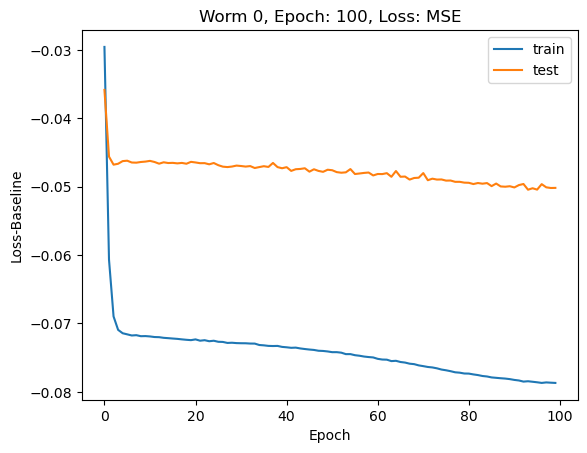

In [210]:
print("Start Training!")
# train
for i in range(len(dataset) - 5):
    print("--------worm " + "No. " + str(i) + "--------")
    # train_loader = worm_train[i]
    # test_loader = worm_test[i]
    train_base_loss_history = []
    train_pred_loss_history = []
    test_base_loss_history = []
    test_pred_loss_history = []
    for e in range(EPOCH):
        train_base_loss = 0
        train_pred_loss = 0
        test_base_loss = 0
        test_pred_loss = 0
        count = 0
        for X_train, Y_train in train_loader:
            X_train, Y_train = torch.tensor(X_train, requires_grad=True), torch.tensor(Y_train, requires_grad=True)
            optimizer.zero_grad()
            # Baseline: loss if the model predicted the residual to be 0
            base = criterion(torch.zeros_like(Y_train), Y_train)
            # print(X_train.shape)
            Y_tr = model(X_train) # .transpose(1, 2))  # Forward pass.
            Y_tr = Y_tr # .transpose(1, 2)
            loss = criterion(Y_tr, Y_train)
            loss.backward(retain_graph=True)
            optimizer.step()  # Update parameters based on gradients.
            train_base_loss += base.detach().item()
            train_pred_loss += loss.detach().item()
            count += 1
        train_base_loss_history.append(train_base_loss / count)
        train_pred_loss_history.append(train_pred_loss / count)
        count = 0
        for X_test, Y_test in test_loader:
            X_test, Y_test = torch.tensor(X_test, requires_grad=True), torch.tensor(Y_test, requires_grad=True)
            optimizer.zero_grad()  # Clear gradients.
            # Baseline: loss if the model predicted the residual to be 0
            base = criterion(torch.zeros_like(Y_test), Y_test)
            # X_test = X_test.reshape((1, X_test.shape[0], X_test.shape[1])).transpose(1, 2)
            Y_pred = model(X_test) #.transpose(1, 2))  # Forward pass.
            Y_pred = Y_pred # .transpose(1, 2)
            loss = criterion(Y_pred, Y_test)
            test_base_loss += base.detach().item()
            test_pred_loss += loss.detach().item()
            count += 1
        test_base_loss_history.append(test_base_loss / count)
        test_pred_loss_history.append(test_pred_loss / count)

        print("epoch = {}, train_loss = {:.4f}, test_loss = {:.4f}".format(e,train_pred_loss_history[-1]-train_base_loss_history[-1],test_pred_loss_history[-1]-test_base_loss_history[-1]))

    delta_train = [train_pred_loss_history[i] - train_base_loss_history[i] for i in range(len(train_base_loss_history))]
    delta_test = [test_pred_loss_history[i] - test_base_loss_history[i] for i in range(len(test_base_loss_history))]
    plt.plot(delta_train)
    plt.plot(delta_test)
    plt.legend(["train", "test"])
    plt.ylabel("Loss-Baseline")
    plt.xlabel("Epoch")
    plt.title("Worm " + str(i) + ", Epoch: " + str(EPOCH) + ", Loss: MSE")
    plt.show()

In [213]:
print(INPUT_SIZE, HIDDEN_SIZE)
print(time_step)

10 100
3


torch.Size([3308, 3, 10])
torch.Size([3308, 3, 10]) torch.Size([3308, 3, 10])


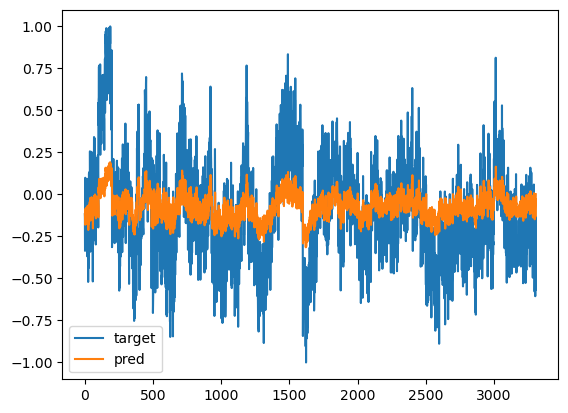

In [214]:
# visualization of prediction
pred = []
target = []
X_test = []
Y_test = []

for i in range(time_step, calcium_data.shape[0]-1):
    X, Y = calcium_data[i-time_step:i, :num_neurons], calcium_data[i-time_step+1:i+1, :num_neurons]
    X_test.append(np.array(X))
    Y_test.append(np.array(Y))

X_test = torch.tensor(np.array(X_test))
Y_test = torch.tensor(np.array(Y_test))
print(X_test.shape)
optimizer.zero_grad()  # Clear gradients.
# Baseline: loss if the model predicted the residual to be 0
base = criterion(torch.zeros_like(Y_test), Y_test)
# X_test = X_test.reshape((1, X_test.shape[0], X_test.shape[1])).transpose(1, 2)
Y_pred = model(X_test) # .transpose(1, 2))  # Forward pass.
Y_pred = Y_pred # .transpose(1, 2)
print(Y_pred.shape, Y_test.shape)

# [batch, time_step, neuron]
plt.plot(Y_test.detach().numpy()[:, 0, 0])
plt.plot(Y_pred.detach().numpy()[:, 0, 0])
plt.legend(["target", "pred"])
plt.show()